In [1]:
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph, IndexedArray
from gensim.models import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt

from graph_visualization import GraphVisualization

### Graph

In [2]:
def get_graph():
    nodes, edges, edge_types, subjects = [], [], [], {}

    nodes.append('vehicle')
    nodes.append('animal')
    nodes.append('car')
    nodes.append('truck')
    nodes.append('airplane')
    nodes.append('motorcycle')
    nodes.append('bus')
    nodes.append('bird')
    nodes.append('cat')
    nodes.append('lion')
    nodes.append('bear')
    nodes.append('boar')

    edges.append({'source': 'car', 'target': 'vehicle'})
    edges.append({'source': 'truck', 'target': 'vehicle'})
    edges.append({'source': 'airplane', 'target': 'vehicle'})
    edges.append({'source': 'motorcycle', 'target': 'vehicle'})
    edges.append({'source': 'bus', 'target': 'vehicle'})
    edges.append({'source': 'bird', 'target': 'animal'})
    edges.append({'source': 'cat', 'target': 'animal'})
    edges.append({'source': 'lion', 'target': 'animal'})
    edges.append({'source': 'bear', 'target': 'animal'})
    edges.append({'source': 'boar', 'target': 'animal'})

    for i in range(10):
        edge_types.append('is-a')

    for node in nodes:
        subjects[node] = 'entity'

    edges_ = pd.DataFrame({
            'source': [e['source'] for e in edges],
            'target': [e['target'] for e in edges],
            'type': edge_types
        })
    
    G = StellarGraph(IndexedArray(index=nodes), edges_, edge_type_column="type")
    
    return {'nodes':nodes, 'edges': edges, 'edge_types': edge_types, 'subjects': pd.Series(data=subjects, index=nodes)}, G

graph, G = get_graph()
G.info()

'StellarGraph: Undirected multigraph\n Nodes: 12, Edges: 10\n\n Node types:\n  default: [12]\n    Features: none\n    Edge types: default-is-a->default\n\n Edge types:\n    default-is-a->default: [10]\n        Weights: all 1 (default)\n        Features: none'

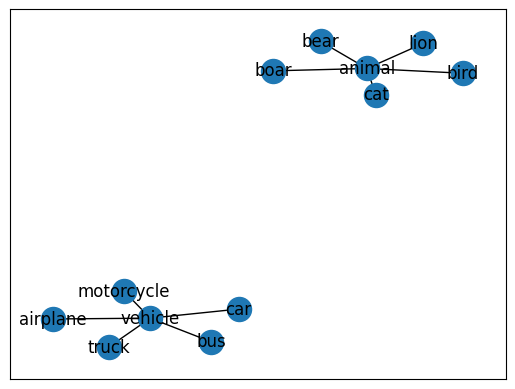

<Figure size 640x480 with 0 Axes>

In [3]:
vis = GraphVisualization()
for edge in graph['edges']:
    vis.addEdge(edge['source'], edge['target'])
vis.visualize()
vis.save('graph.png')

# Embeddings

### Node2Vec

In [42]:
graph_embedding_size=2

def node2vec(G):
        walk_length = 100
        rw = BiasedRandomWalk(G)
        walks = rw.run(
            nodes=G.nodes(),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=10,  # number of random walks per root node
            p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
            q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
            weighted=False,  # for weighted random walks
            seed=42,  # random seed fixed for reproducibility
        )

        model = Word2Vec(
            walks,  vector_size=graph_embedding_size, window=5, min_count=0, sg=1, workers=1
        )

        return pd.DataFrame([(key, vector) for key,vector in zip(model.wv.index_to_key, model.wv.vectors)])

node2vec = node2vec(G)

node2vec[2] = ['entity', 'entity', 'animal', 'vehicle', 'vehicle', 'vehicle', 'animal', 'animal', 'animal', 'vehicle', 'vehicle', 'animal']
node2vec

,0,1,2
0,animal,"[-0.48878464, 2.3753114]",entity
1,vehicle,"[2.3485785, 0.72030723]",entity
2,cat,"[-0.4603705, 2.3041046]",animal
3,airplane,"[2.225878, 0.6491519]",vehicle
4,motorcycle,"[2.088705, 0.64655316]",vehicle
5,truck,"[2.1654453, 0.65733767]",vehicle
6,boar,"[-0.4308193, 2.1980736]",animal
7,lion,"[-0.390708, 2.2156603]",animal
8,bird,"[-0.46232426, 2.2636313]",animal
9,bus,"[2.1728177, 0.68883413]",vehicle


In [5]:
from stellargraph.core import StellarGraph
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph.losses import graph_log_likelihood
from stellargraph import datasets
from stellargraph.utils import plot_history

from matplotlib import pyplot as plt
from tensorflow.keras import optimizers, Model, layers, regularizers
import tensorflow as tf
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML

import networkx as nx
import random
import numpy as np
import pandas as pd
import os

In [6]:
# dataset = datasets.Cora()
# display(HTML(dataset.description))
# G2, subjects = dataset.load()
subjects = graph['subjects']

In [7]:
generator = AdjacencyPowerGenerator(G, num_powers=10)

wys = WatchYourStep(
    generator,
    num_walks=80,
    embedding_dimension=2,
    attention_regularizer=regularizers.l2(0.5),
)
x_in, x_out = wys.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=graph_log_likelihood, optimizer=tf.keras.optimizers.Adam(1e-3))

In [8]:
batch_size = 1
train_gen = generator.flow(batch_size=batch_size, num_parallel_calls=10)

history = model.fit(
    train_gen, epochs=10, verbose=1, steps_per_epoch=int(len(G.nodes()) // batch_size)
)

Epoch 1/10


D:\Programs\miniconda3\envs\tf-37\lib\site-packages\stellargraph\core\experimental.py:12: ExperimentalWarning: graph_log_likelihood is experimental: lack of unit tests (see: https://github.com/stellargraph/stellargraph/issues/804). It may be difficult to use and may have major changes at any time.
  # distributed under the License is distributed on an "AS IS" BASIS,


InternalError: 2 root error(s) found.
  (0) Internal:  Blas xGEMV launch failed : a.shape=[1,12,10], b.shape=[1,10,1], m=12, n=1, k=10
	 [[node model/attentive_walk/einsum/Einsum (defined at D:\Programs\miniconda3\envs\tf-37\lib\site-packages\stellargraph\layer\watch_your_step.py:104) ]]
	 [[gradient_tape/model/dense/MatMul/_36]]
  (1) Internal:  Blas xGEMV launch failed : a.shape=[1,12,10], b.shape=[1,10,1], m=12, n=1, k=10
	 [[node model/attentive_walk/einsum/Einsum (defined at D:\Programs\miniconda3\envs\tf-37\lib\site-packages\stellargraph\layer\watch_your_step.py:104) ]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1111]

Errors may have originated from an input operation.
Input Source operations connected to node model/attentive_walk/einsum/Einsum:
 IteratorGetNext (defined at C:\Users\cuney\AppData\Local\Temp\ipykernel_14864\969523391.py:5)	
 model/attentive_walk/Softmax (defined at D:\Programs\miniconda3\envs\tf-37\lib\site-packages\stellargraph\layer\watch_your_step.py:103)

Input Source operations connected to node model/attentive_walk/einsum/Einsum:
 IteratorGetNext (defined at C:\Users\cuney\AppData\Local\Temp\ipykernel_14864\969523391.py:5)	
 model/attentive_walk/Softmax (defined at D:\Programs\miniconda3\envs\tf-37\lib\site-packages\stellargraph\layer\watch_your_step.py:103)

Function call stack:
train_function -> train_function


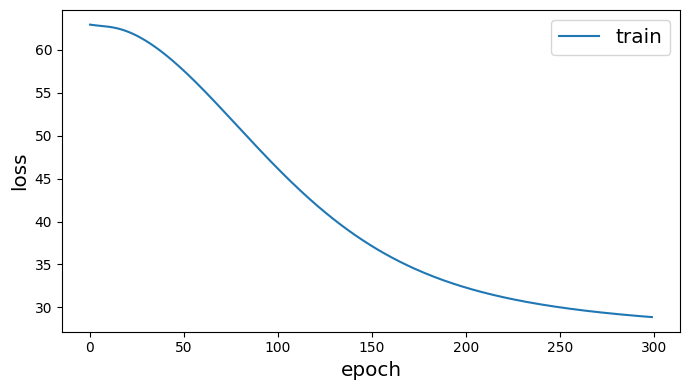

In [56]:
plot_history(history)

In [ ]:
embeddings = wys.embeddings()

### Visualization

D:\Programs\miniconda3\envs\tf-37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
D:\Programs\miniconda3\envs\tf-37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


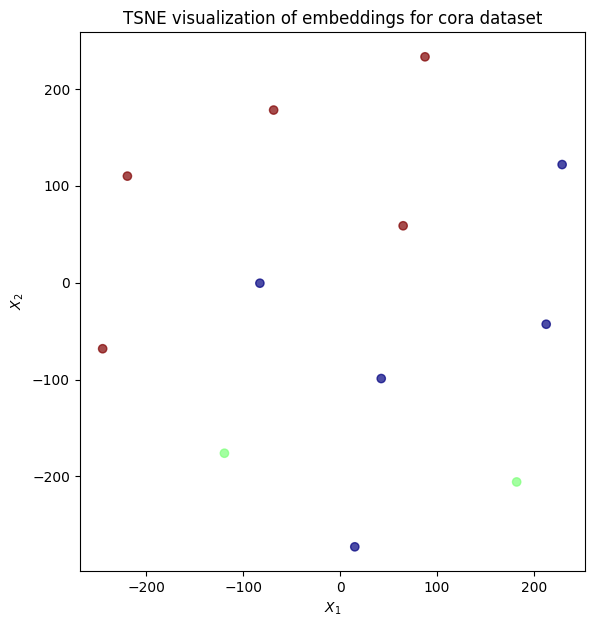

In [53]:
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

nodelist = list(G.nodes())

labels = node2vec[2]
# labels = subjects.loc[nodelist]
target_encoding = OneHotEncoder(sparse=False)
label_vectors = target_encoding.fit_transform(labels.values.reshape(-1, 1))

transform = TSNE

embeddings = node2vec[1].tolist()

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(embeddings), index=nodelist)

emb_transformed["label"] = np.argmax(label_vectors, 1)

alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)

ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of embeddings for cora dataset".format(
        transform.__name__
    )
)
plt.show()